In [172]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from statistics import mean

In [3]:
os.chdir(r"assignment3")
os.getcwd()

'd:\\UF_Multi-Model_ML\\assignment3'

Feature Extraction & Data Exploration

In [127]:
def normalize(values, bounds): #-----------------Function for normalizing data between -1 and 1
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

  0%|          | 0/4 [00:00<?, ?it/s]

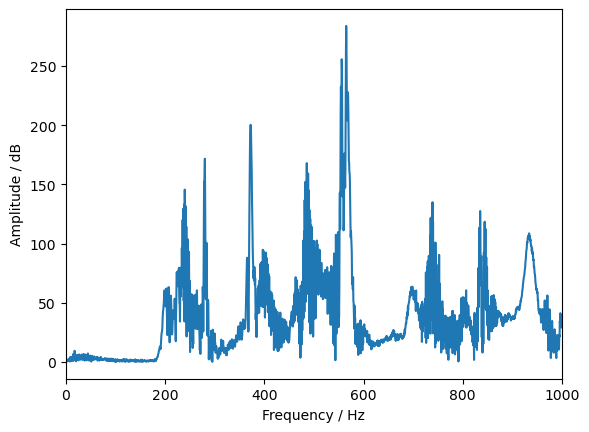

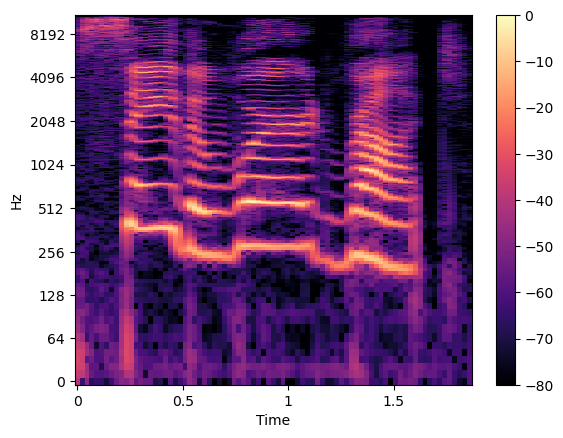

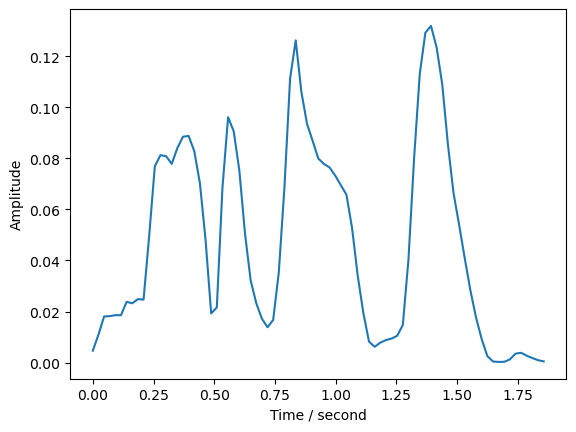

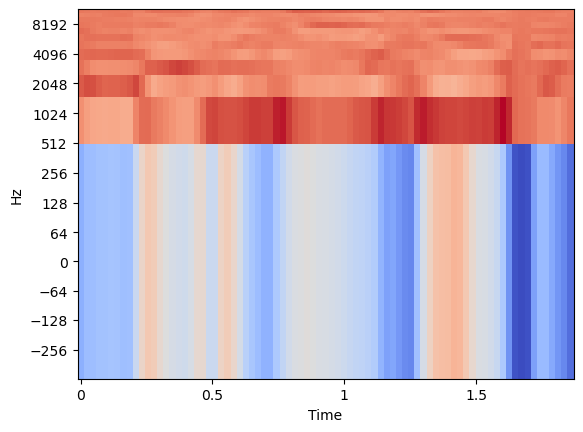

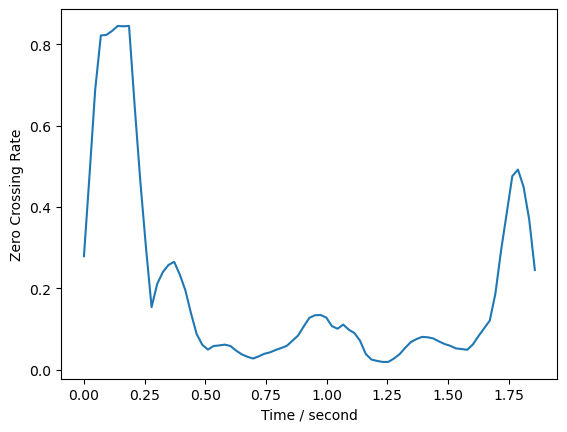

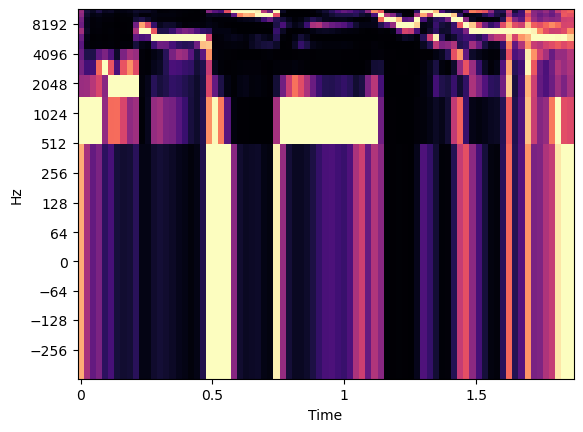

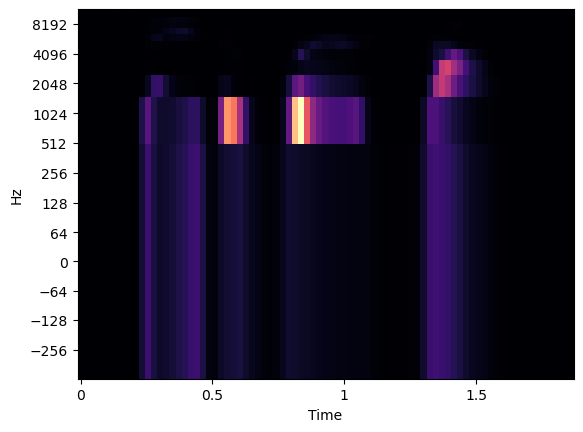

 25%|██▌       | 1/4 [00:15<00:45, 15.25s/it]

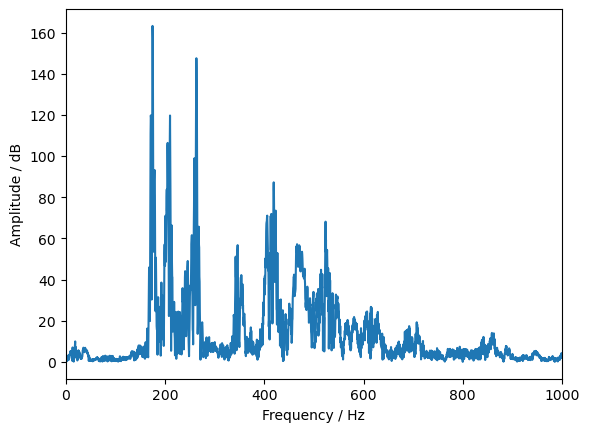

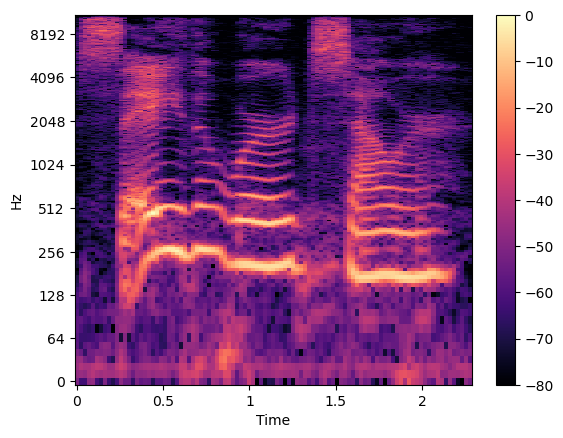

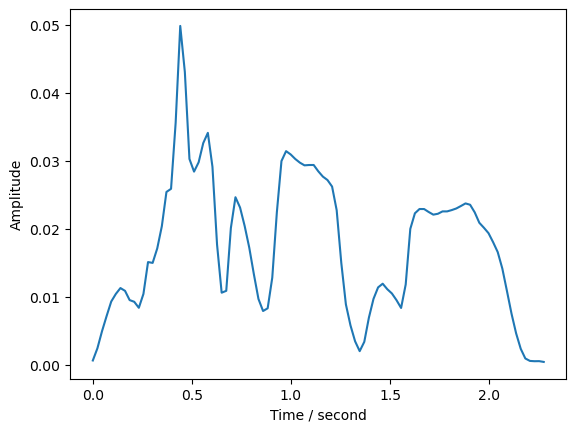

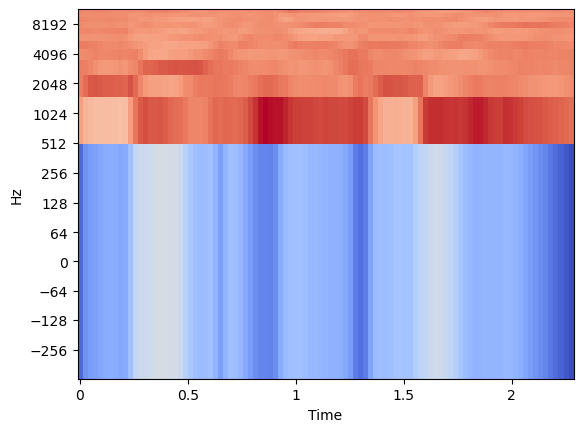

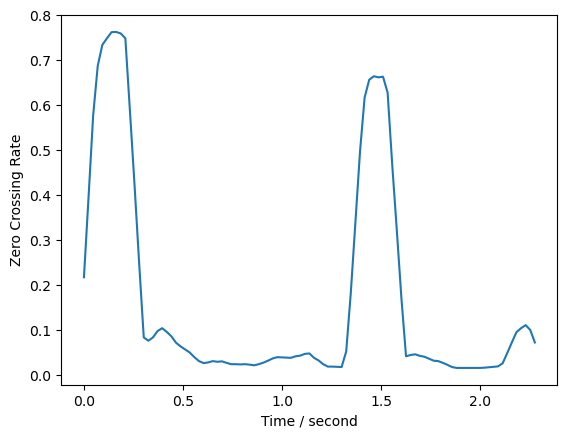

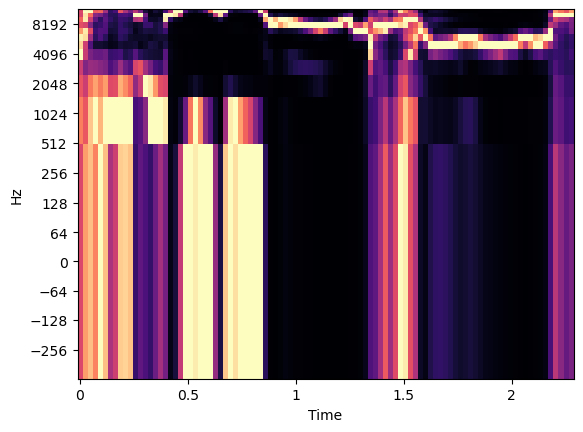

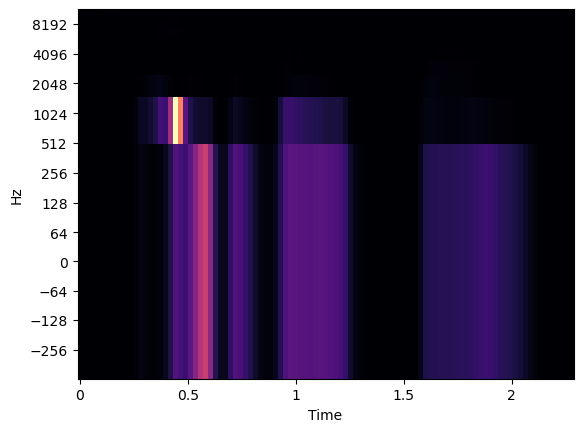

 50%|█████     | 2/4 [00:29<00:29, 14.57s/it]

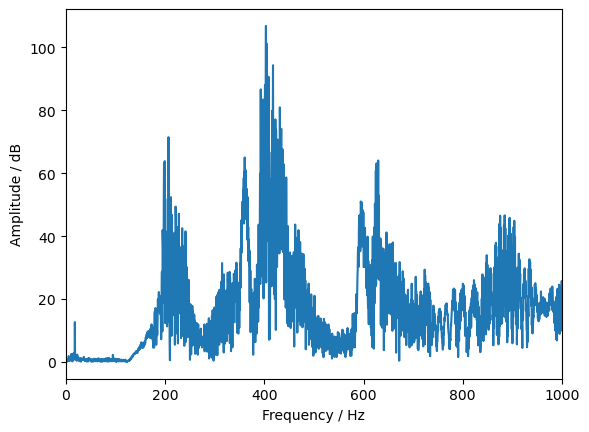

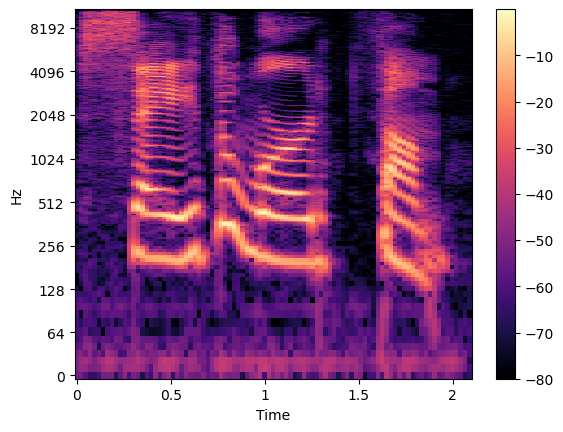

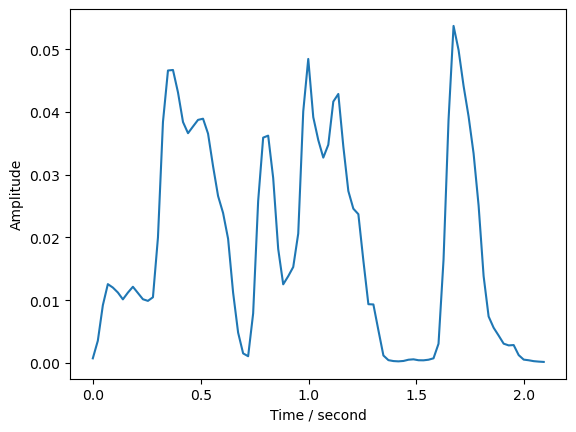

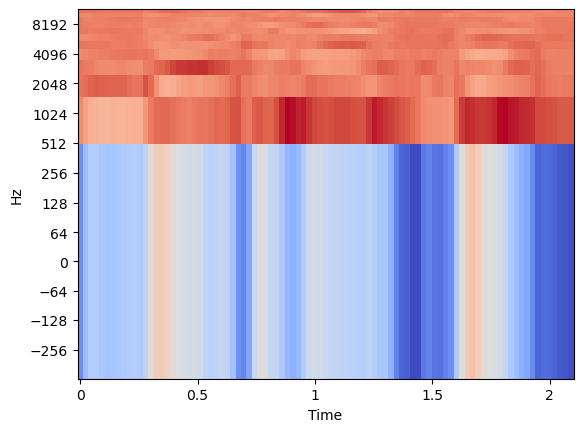

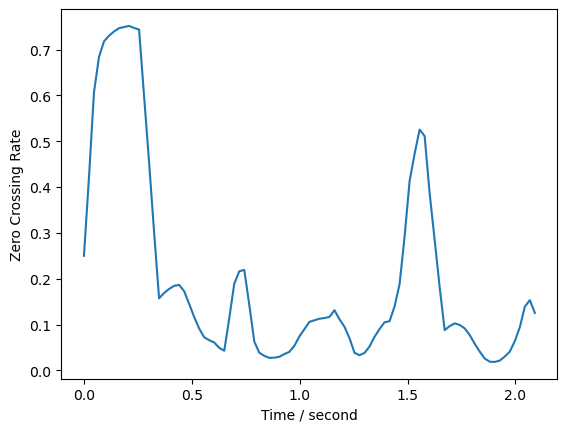

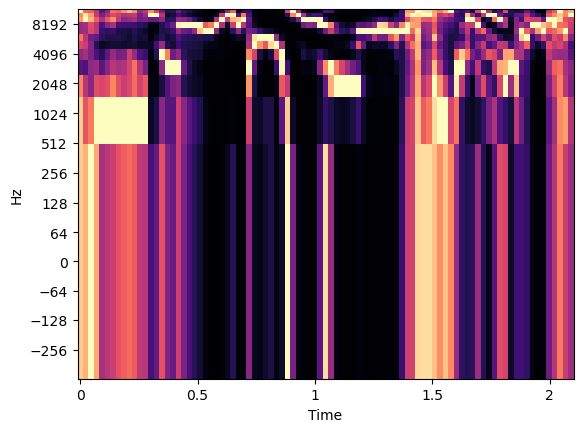

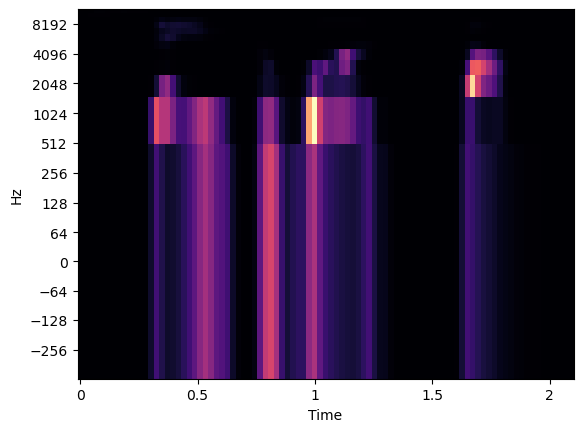

 75%|███████▌  | 3/4 [00:43<00:14, 14.18s/it]

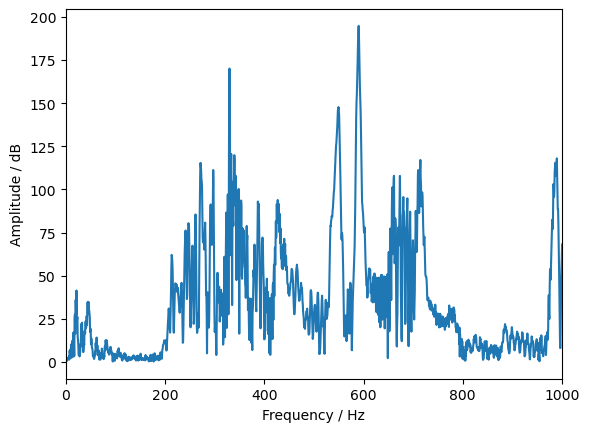

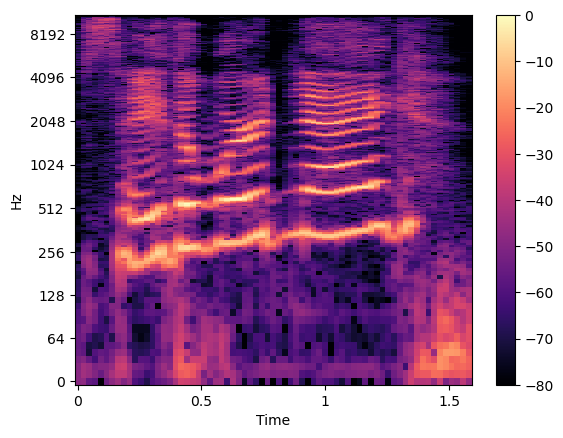

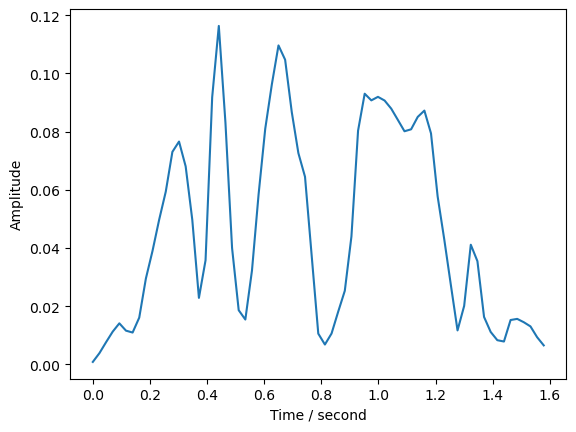

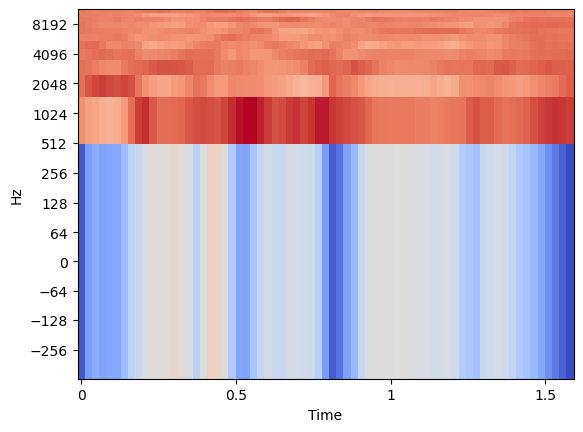

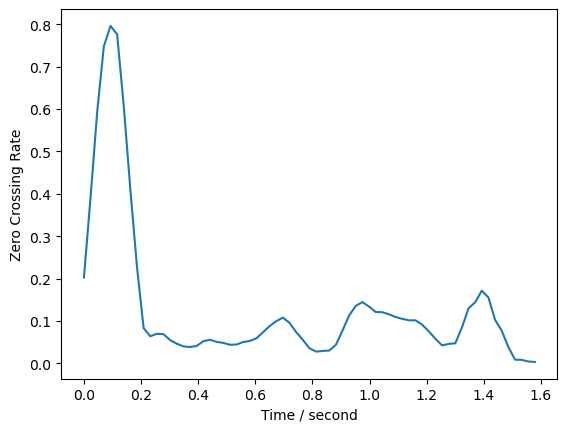

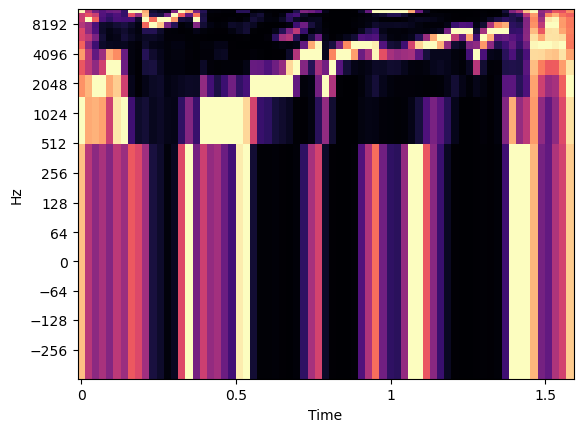

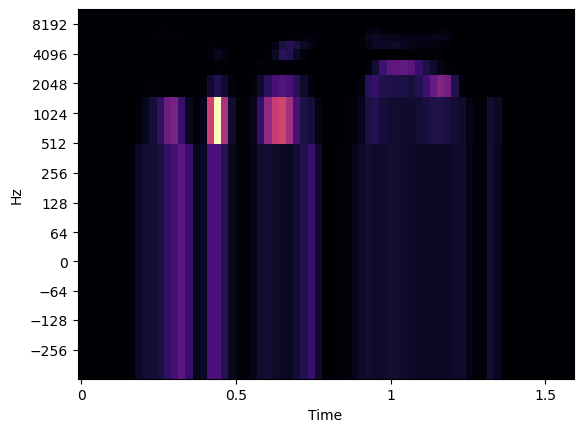

100%|██████████| 4/4 [00:56<00:00, 14.03s/it]


In [173]:
import librosa
import matplotlib.pyplot as plt

happy_train = []
happy_test = []
sad_train = []
sad_test= []
angry_train = []
angry_test = []
fear_train = []
fear_test = []

happy_train_avg = []
happy_test_avg = []
sad_train_avg = []
sad_test_avg = []
angry_train_avg = []
angry_test_avg = []
fear_train_avg = []
fear_test_avg = []

for dir in tqdm(os.listdir("data_folder")):
    count = 0
    for file in tqdm(os.listdir(f"./data_folder/{dir}")):
        signal, sample_rate = librosa.load(f'./data_folder/{dir}/{file}')
        k = np.arange(len(signal))
        T = len(signal)/sample_rate
        freq = k/T

        if count == 1:
            DATA_0 = np.fft.fft(signal)
            abs_DATA_0 = abs(DATA_0)
            plt.figure(2)
            plt.plot(freq, abs_DATA_0)
            plt.xlabel("Frequency / Hz")
            plt.ylabel("Amplitude / dB")
            plt.xlim([0, 1000])
            plt.show()

            D = librosa.stft(signal)  # STFT of y
            S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
            plt.figure(3)
            librosa.display.specshow(S_db, x_axis='time', y_axis='log')
            plt.colorbar()
            plt.show()

        df_loudness = pd.DataFrame()
        S, phase = librosa.magphase(librosa.stft(signal))
        rms = librosa.feature.rms(S=S)
        df_loudness['Loudness'] = rms[0]

        if count == 1:
            plt.figure(4)
            times = librosa.times_like(rms)
            plt.plot(times, rms[0])
            plt.xlabel("Time / second")
            plt.ylabel("Amplitude")
            plt.show()

        df_mfccs = pd.DataFrame()
        mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=12)
        for n_mfcc in range(len(mfccs)):
            df_mfccs['MFCC_%d'%(n_mfcc+1)] = mfccs.T[n_mfcc]
        
        if count == 1:
            plt.figure(5)
            librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time', y_axis='log')
            plt.show()

        df_zero_crossing_rate = pd.DataFrame()
        zcr = librosa.feature.zero_crossing_rate(y=signal)
        df_zero_crossing_rate['ZCR'] = zcr[0]

        if count == 1:
            plt.figure(6)
            times = librosa.times_like(zcr)
            plt.plot(times, zcr[0])
            plt.xlabel("Time / second")
            plt.ylabel("Zero Crossing Rate")
            plt.show()

        df_chroma = pd.DataFrame()
        chromagram = librosa.feature.chroma_stft(y=signal, sr=sample_rate)
        for n_chroma in range(len(chromagram)):
            df_chroma['Chroma_%d'%(n_chroma+1)] = chromagram.T[n_chroma]

        if count == 1:
            plt.figure(7)
            librosa.display.specshow(chromagram, sr=sample_rate, x_axis='time', y_axis='log')
            plt.show()

        df_mel_spectrogram = pd.DataFrame()
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=12)
        for n_mel in range(len(mel_spectrogram)):
            df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)] = mel_spectrogram.T[n_mel]

        if count == 1:
            plt.figure(8)
            librosa.display.specshow(mel_spectrogram, sr=sample_rate, x_axis='time', y_axis='log')
            plt.show()

        feature_matrix = pd.concat([df_loudness, df_mfccs, df_zero_crossing_rate, df_chroma, df_mel_spectrogram], axis=1)
        
        avg = {}
        for col in feature_matrix.columns:
            temp = np.array(feature_matrix[col].dropna())
            data = normalize(temp,{'actual': {'lower': feature_matrix[col].min(), 'upper': feature_matrix[col].max()}, 'desired': {'lower': -1, 'upper': 1}})               
            feature_matrix.replace(temp, data, inplace=True)
            avg[col] = mean(data)

        count = count + 1
        if dir == "happy":
            if count > 70:
                happy_test.append(feature_matrix)
                happy_test_avg.append(avg)
            else:
                happy_train.append(feature_matrix)
                happy_train_avg.append(avg)
        if dir == "sad":
            if count > 70:
                sad_test.append(feature_matrix)
                sad_test_avg.append(avg)
            else:
                sad_train.append(feature_matrix)
                sad_train_avg.append(avg)

        if dir == "angry":
            if count > 70:
                angry_test.append(feature_matrix)
                angry_test_avg.append(avg)
            else:
                angry_train.append(feature_matrix)
                angry_train_avg.append(avg)
        if dir == "fear":
            if count > 70:
                fear_test.append(feature_matrix)
                fear_test_avg.append(avg)
            else:
                fear_train.append(feature_matrix)
                fear_train_avg.append(avg)


Creating Classifiers

In [356]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report

In [321]:
happy = pd.DataFrame(happy_train_avg)
sad = pd.DataFrame(sad_train_avg)
angry = pd.DataFrame(angry_train_avg)
fear = pd.DataFrame(fear_train_avg)

frame = [happy,sad,angry,fear]
train = pd.concat(frame, ignore_index=True)

happy = pd.DataFrame(happy_test_avg)
sad = pd.DataFrame(sad_test_avg)
angry = pd.DataFrame(angry_test_avg)
fear = pd.DataFrame(fear_test_avg)

frame = [happy,sad,angry,fear]
test = pd.concat(frame, ignore_index=True)

In [322]:
test

,Loudness,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,Mel_Spectrogram_3,Mel_Spectrogram_4,Mel_Spectrogram_5,Mel_Spectrogram_6,Mel_Spectrogram_7,Mel_Spectrogram_8,Mel_Spectrogram_9,Mel_Spectrogram_10,Mel_Spectrogram_11,Mel_Spectrogram_12
0,-0.433615,0.722786,0.658103,0.586686,0.573339,0.616018,0.632653,0.663217,0.664624,0.634220,...,-0.786439,-0.796570,-0.804427,-0.807197,-0.801770,-0.805120,-0.805360,-0.797104,-0.730255,-0.723414
1,-0.394231,0.700857,0.639815,0.585572,0.562167,0.624075,0.694707,0.682722,0.674348,0.711019,...,-0.747182,-0.789179,-0.794995,-0.796752,-0.797174,-0.776199,-0.769103,-0.729154,-0.705626,-0.706214
2,-0.376072,0.674661,0.573626,0.586200,0.630969,0.678121,0.706085,0.736846,0.727982,0.726171,...,-0.730357,-0.770431,-0.793578,-0.803491,-0.798149,-0.803488,-0.806066,-0.802391,-0.701758,-0.741522
3,-0.393768,0.632497,0.577708,0.576463,0.587718,0.616492,0.640202,0.674875,0.664591,0.638459,...,-0.711487,-0.752280,-0.780188,-0.796017,-0.791499,-0.789664,-0.799486,-0.782551,-0.722120,-0.709712
4,-0.417309,0.626451,0.559980,0.598869,0.637552,0.655476,0.687413,0.694482,0.685980,0.580683,...,-0.771192,-0.782183,-0.799712,-0.808368,-0.812545,-0.817497,-0.659595,-0.735577,-0.704818,-0.537482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,-0.347849,0.720162,0.590968,0.552632,0.593245,0.626665,0.623212,0.591017,0.555668,0.521117,...,-0.599491,-0.706478,-0.758306,-0.782752,-0.786976,-0.756263,-0.443586,-0.637395,-0.674053,-0.717265
116,-0.392308,0.761046,0.625163,0.525660,0.517978,0.588423,0.636879,0.572437,0.580429,0.591611,...,-0.671382,-0.747312,-0.757380,-0.771209,-0.765303,-0.593391,-0.746152,-0.810314,-0.806679,-0.779460
117,-0.203369,0.763986,0.643233,0.584121,0.591890,0.584866,0.597646,0.648721,0.655950,0.641841,...,-0.644275,-0.763036,-0.789178,-0.777022,-0.765760,-0.778990,-0.785756,-0.794367,-0.744586,-0.563619
118,-0.128781,0.662498,0.582834,0.555859,0.576068,0.582423,0.599880,0.608335,0.583998,0.577968,...,-0.765607,-0.782718,-0.799048,-0.804898,-0.808974,-0.820088,-0.820479,-0.806281,-0.725927,-0.686923


In [348]:
train_labels = np.zeros((len(train.index),),dtype='object')
print(len(train_labels))
train_labels[0:70] = "happy" #-----------happy data
train_labels[70:140] = "sad" #-----------sad data
train_labels[140:210] = "angry" #-----------angry data
train_labels[210:280] = "fear" #-----------fear data

test_labels = np.ones((len(test.index),),dtype='object')
print(len(test_labels))
test_labels[0:30] = "happy" #-----------happy data
test_labels[30:60] = "sad" #-----------sad data
test_labels[60:90] = "angry" #-----------angry data
test_labels[90:120] = "fear" #-----------fear data

280
120


In [349]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [350]:
train_labels = pd.DataFrame(train_labels, columns={'emotion'})
test_labels = pd.DataFrame(test_labels, columns={'emotion'})

In [351]:
train_labels

,emotion
0,happy
1,happy
2,happy
3,happy
4,happy
...,...
275,fear
276,fear
277,fear
278,fear


In [373]:
all_data = pd.concat([train, test], ignore_index=True)
labels = pd.concat([train_labels, test_labels], ignore_index=True)
all_data = pd.concat([all_data, labels], axis=1)
all_data

,Loudness,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,Mel_Spectrogram_4,Mel_Spectrogram_5,Mel_Spectrogram_6,Mel_Spectrogram_7,Mel_Spectrogram_8,Mel_Spectrogram_9,Mel_Spectrogram_10,Mel_Spectrogram_11,Mel_Spectrogram_12,emotion
0,-0.362260,0.728381,0.651986,0.611295,0.611864,0.635930,0.643652,0.648722,0.674184,0.568384,...,-0.789613,-0.799232,-0.812948,-0.810487,-0.805340,-0.688733,-0.719513,-0.689378,-0.478915,happy
1,-0.285831,0.680329,0.590372,0.580772,0.617387,0.654136,0.651013,0.648260,0.630901,0.594353,...,-0.821690,-0.822432,-0.823822,-0.828573,-0.827702,-0.825893,-0.516863,-0.689280,-0.645475,happy
2,-0.348705,0.670447,0.584088,0.569414,0.622912,0.700144,0.716506,0.693731,0.680180,0.676271,...,-0.801085,-0.800523,-0.789184,-0.795482,-0.783702,-0.691443,-0.697621,-0.626559,-0.427902,happy
3,-0.322929,0.638871,0.625909,0.633525,0.653839,0.695099,0.714477,0.725881,0.703889,0.691130,...,-0.718650,-0.741552,-0.757792,-0.748586,-0.728272,-0.672206,-0.633059,-0.535193,-0.646184,happy
4,-0.426815,0.775453,0.659647,0.571394,0.536985,0.535874,0.587937,0.643423,0.694087,0.732636,...,-0.798766,-0.813927,-0.817569,-0.807856,-0.798391,-0.768688,-0.737932,-0.662917,-0.552342,happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.347849,0.720162,0.590968,0.552632,0.593245,0.626665,0.623212,0.591017,0.555668,0.521117,...,-0.706478,-0.758306,-0.782752,-0.786976,-0.756263,-0.443586,-0.637395,-0.674053,-0.717265,fear
396,-0.392308,0.761046,0.625163,0.525660,0.517978,0.588423,0.636879,0.572437,0.580429,0.591611,...,-0.747312,-0.757380,-0.771209,-0.765303,-0.593391,-0.746152,-0.810314,-0.806679,-0.779460,fear
397,-0.203369,0.763986,0.643233,0.584121,0.591890,0.584866,0.597646,0.648721,0.655950,0.641841,...,-0.763036,-0.789178,-0.777022,-0.765760,-0.778990,-0.785756,-0.794367,-0.744586,-0.563619,fear
398,-0.128781,0.662498,0.582834,0.555859,0.576068,0.582423,0.599880,0.608335,0.583998,0.577968,...,-0.782718,-0.799048,-0.804898,-0.808974,-0.820088,-0.820479,-0.806281,-0.725927,-0.686923,fear


In [352]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(train, train_labels, random_state=0)
x_test, y_test = shuffle(test, test_labels, random_state=0)

In [ ]:
lg = LogisticRegression(random_state=0).fit(x_train,y_train)
knn = KNeighborsClassifier(n_neighbors=4).fit(x_train, y_train)
svm = SVC(probability=True).fit(x_train, y_train)

In [364]:
lg_predict = lg.predict(x_test)
knn_predict = knn.predict(x_test)
svm_predict = svm.predict(x_test)

lg_pred_proba = lg.predict_proba(x_test)
knn_pred_proba = knn.predict_proba(x_test)
svm_pred_proba = svm.predict_proba(x_test)

In [365]:
print(classification_report(y_test, lg_predict))

              precision    recall  f1-score   support

       angry       0.84      0.87      0.85        30
        fear       0.81      0.73      0.77        30
       happy       0.88      0.93      0.90        30
         sad       0.93      0.93      0.93        30

    accuracy                           0.87       120
   macro avg       0.87      0.87      0.87       120
weighted avg       0.87      0.87      0.87       120



In [366]:
print(classification_report(y_test, knn_predict))

              precision    recall  f1-score   support

       angry       0.79      0.90      0.84        30
        fear       0.77      0.67      0.71        30
       happy       0.77      0.90      0.83        30
         sad       1.00      0.83      0.91        30

    accuracy                           0.82       120
   macro avg       0.83      0.83      0.82       120
weighted avg       0.83      0.82      0.82       120



In [367]:
print(classification_report(y_test, svm_predict))

              precision    recall  f1-score   support

       angry       0.79      0.87      0.83        30
        fear       0.73      0.63      0.68        30
       happy       0.80      0.93      0.86        30
         sad       1.00      0.87      0.93        30

    accuracy                           0.82       120
   macro avg       0.83      0.83      0.82       120
weighted avg       0.83      0.82      0.82       120



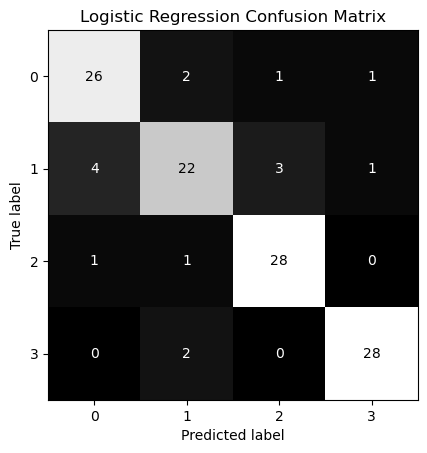

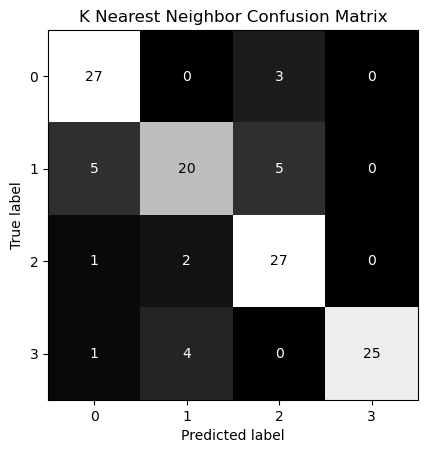

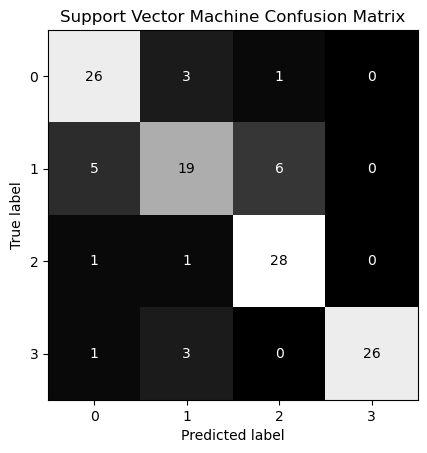

In [369]:
models = ['Logistic Regression', 'K Nearest Neighbor', 'Support Vector Machine']
predictions = [lg_predict, knn_predict, svm_predict]
pred_probabilities = [lg_pred_proba, knn_pred_proba, svm_pred_proba]

y_test_numpy = np.array(y_test)

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test_numpy.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

Out of all the clasifiers, it seems that Logistic Regression did the best. Therefore we will now try to test Logistic Regression on single features.

In [389]:
all_data.columns

Index(['Loudness', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6',
       'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'ZCR',
       'Chroma_1', 'Chroma_2', 'Chroma_3', 'Chroma_4', 'Chroma_5', 'Chroma_6',
       'Chroma_7', 'Chroma_8', 'Chroma_9', 'Chroma_10', 'Chroma_11',
       'Chroma_12', 'Mel_Spectrogram_1', 'Mel_Spectrogram_2',
       'Mel_Spectrogram_3', 'Mel_Spectrogram_4', 'Mel_Spectrogram_5',
       'Mel_Spectrogram_6', 'Mel_Spectrogram_7', 'Mel_Spectrogram_8',
       'Mel_Spectrogram_9', 'Mel_Spectrogram_10', 'Mel_Spectrogram_11',
       'Mel_Spectrogram_12', 'emotion'],
      dtype='object')

In [426]:
MFCC =  all_data.iloc[:,1:13]
Chroma = all_data.iloc[:,14:26]
Mel_Spectrogram = all_data.iloc[:,26:38]
features = [MFCC, Chroma, Mel_Spectrogram]
names = np.array(["MFCC", "Chroma", "Mel_Spectrogram"])
emotion = all_data["emotion"]

In [428]:
from sklearn.model_selection import train_test_split

for index, name in enumerate(features):
    x_train, x_test, y_train, y_test = train_test_split(name, emotion, test_size=0.3, random_state=0)
    lg_predict = LogisticRegression(random_state=0).fit(x_train, y_train).predict(x_test)
    print("Classification Report for " + names[index])
    print(classification_report(y_test, lg_predict))

Classification Report for MFCC
              precision    recall  f1-score   support

       angry       0.49      0.69      0.57        32
        fear       0.62      0.54      0.58        24
       happy       0.77      0.45      0.57        38
         sad       0.78      0.96      0.86        26

    accuracy                           0.64       120
   macro avg       0.67      0.66      0.64       120
weighted avg       0.67      0.64      0.63       120

Classification Report for Chroma
              precision    recall  f1-score   support

       angry       0.67      0.50      0.57        32
        fear       0.39      0.54      0.46        24
       happy       0.82      0.71      0.76        38
         sad       0.50      0.58      0.54        26

    accuracy                           0.59       120
   macro avg       0.59      0.58      0.58       120
weighted avg       0.62      0.59      0.60       120

Classification Report for Mel_Spectrogram
              precision 

It seems that Mel_Spetrogram came out the most accurate out of the features, however it was not by much